## Import libraries and data

In [23]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as mae
from sklearn import metrics

Sources:  
1. https://www.kaggle.com/datasets/sazid28/advertising.csv
2. https://www.thinkwithgoogle.com/marketing-strategies/data-and-measurement/marketing-mix-modeling-tutorial/
3. https://www.latentview.com/marketing-mix-modeling/
4. https://bowtiedraptor.substack.com/p/log-linear-model
5. https://towardsdatascience.com/improving-marketing-mix-modeling-using-machine-learning-approaches-25ea4cd6994b
6. https://towardsdatascience.com/multi-armed-bandits-thompson-sampling-algorithm-fea205cf31df
7. https://towardsdatascience.com/an-complete-guide-to-building-a-marketing-mix-model-in-2021-fb53975be754

In [3]:
df = pd.read_csv('MMM_data.csv')
df = df.iloc[:,1:]

In [182]:
df.head()

,TV,radio,newspaper,sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9


Our data is a collection of weeks, and $ spent on different media sources, + # of sales made that week.

## EDA

1. Correlation matrix
2. Pair plots
3. Feature importance

1. TV is most heavily correlated with sales, while radio and newspaper tended to be used together.

<Axes: >

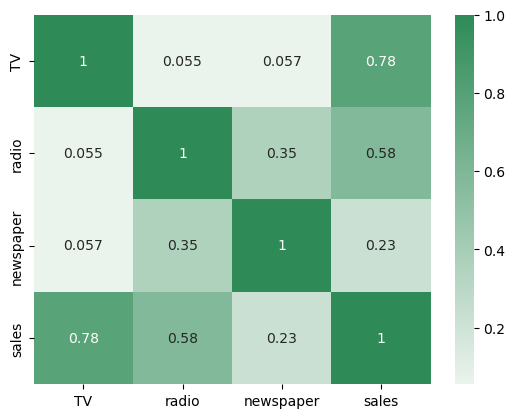

In [5]:
corr = df.corr()
sns.heatmap(corr, xticklabels = corr.columns, yticklabels = corr.columns, annot = True, cmap = sns.light_palette(color='seagreen', as_cmap=True))

2. The relationship looks strongest for TV, especially when moving from no TV to some TV

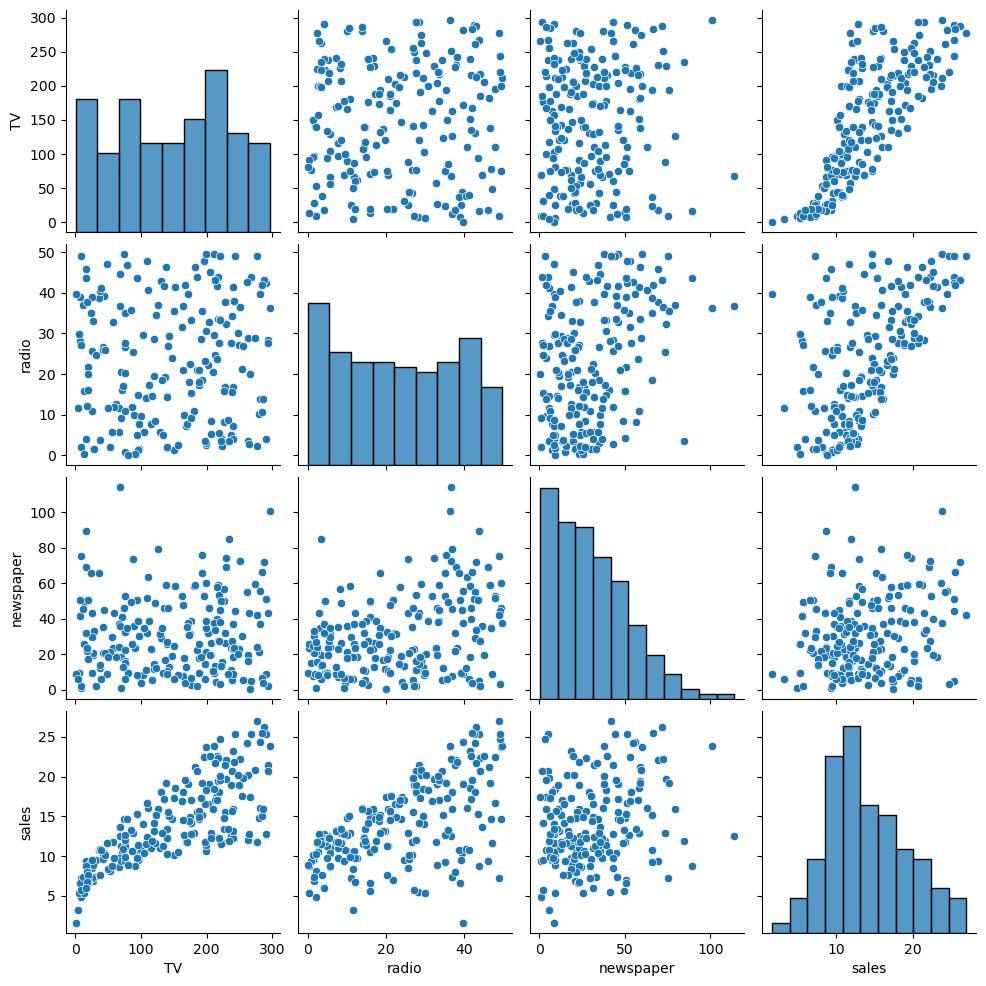

In [6]:
sns.pairplot(df)

3a. Curiously, radio has the largest linear coefficient. Presumably this is because TV values tend to be higher. We'll try random forest too

In [7]:
from sklearn.linear_model import LinearRegression

<BarContainer object of 3 artists>

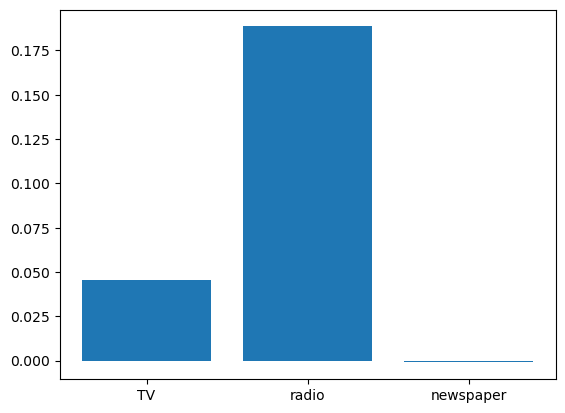

In [8]:
# create a multiple linear regression model to predict sales
X = df.iloc[:,0:3]
y = df.iloc[:,3]
model = LinearRegression()
model.fit(X,y)

# map size of model coefficients
plt.bar(X.columns, model.coef_)

In [9]:
df.head()

,TV,radio,newspaper,sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9


3b. With a random forest, which isn't as linearly tied to the values themselves, shows coefficients that make more sense given our other EDA

<BarContainer object of 3 artists>

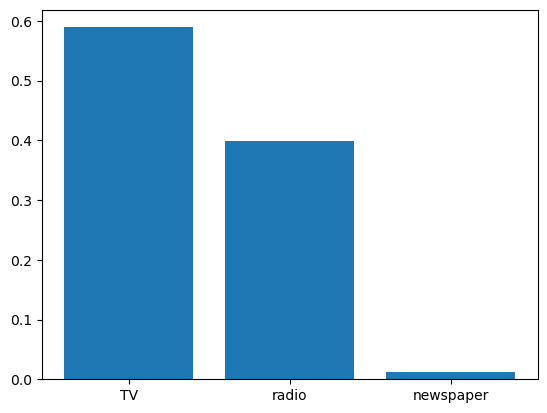

In [67]:
# build random forest model (using previously constructed X and y)
# this block of code is ripped directly from towardsdatascience
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=0)
rf_model = RandomForestRegressor(random_state=0)
rf_model.fit(X_train, y_train)
pred = rf_model.predict(X_test) 
# Store results for later
rf_results = pd.DataFrame({'actual': y_test, 'pred':pred})
# Bar chart of feature importance
rf_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
plt.bar(X.columns, rf_importances)

## Model

As a starting point we'll use ordinary least squares (OLS, basically linear regression), because it's simple and interpretable

In [13]:
import statsmodels.formula.api as sm

In [14]:
df.head()

,TV,radio,newspaper,sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9


In [15]:
# OLS. note that there are no hyperparameters, so we don't need to create a test train split. 
# The model will still be generalizable to new data!
import statsmodels.api as sm

# create a matrix of predictors (X) and a vector of response variable (y)
X = df.loc[:, df.columns!='sales']
y = df['sales']

# add a constant term to the matrix of predictors
X = sm.add_constant(X)

# fit the ordinary least squares model
model = sm.OLS(y, X).fit()

# print the summary of the model
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     570.3
Date:                Thu, 06 Apr 2023   Prob (F-statistic):           1.58e-96
Time:                        22:34:09   Log-Likelihood:                -386.18
No. Observations:                 200   AIC:                             780.4
Df Residuals:                     196   BIC:                             793.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.9389      0.312      9.422      0.0

<Axes: >

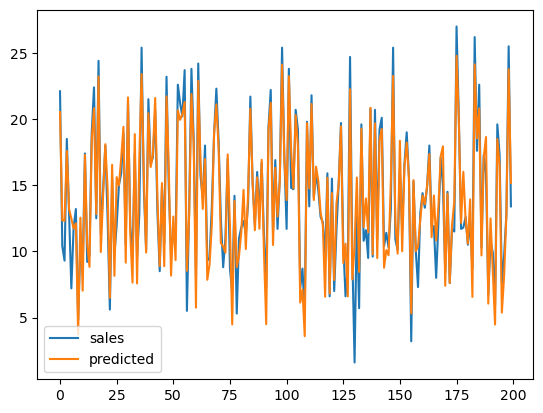

In [16]:
# create df of sales and predicted sales
y_pred = model.predict()
results = df.iloc[:,3:4].copy()
results['predicted'] = y_pred

# plot it
results.plot()

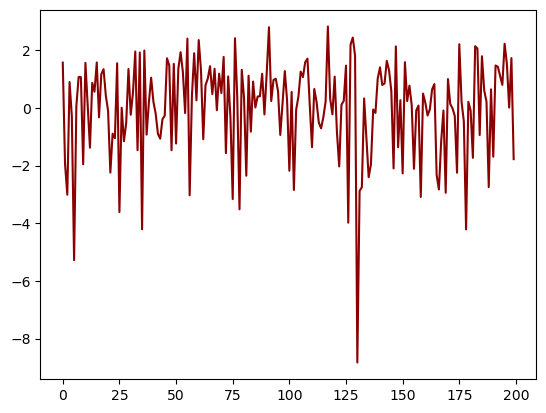

In [17]:
# plot the error
plt.plot(results['sales'] - results['predicted'], color='darkred')

The data doesn't actually look linear in our EDA; the relationship is more logarithmic. Let's use a log-linear model to see if we can reduce the error.

In [78]:
#todo: visualize the np.log'd data to see if it has a linear shape

In [18]:
# test/train data
# note that we skipped this in the linear regression
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=0)
# taking the log of the training y variable turns LinearRegression into a log-linear model
y_log_train = np.log(y_train)
clf = LinearRegression().fit(X_train, y_log_train)

In [19]:
# make predictions using logarithmically adjusted model, and add results to df for analysis
pred = np.exp(clf.predict(X_test))
loglin_results = pd.DataFrame({'y_test':y_test.values, 'predictions':np.round(pred,1)})
loglin_results.head()

,y_test,predictions
0,11.3,9.6
1,8.4,8.0
2,8.7,7.9
3,25.4,27.6
4,11.7,11.6


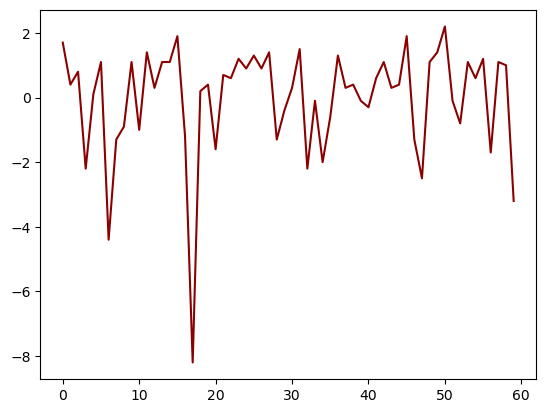

In [20]:
plt.plot(loglin_results['y_test'] - loglin_results['predictions'], color='darkred')

Finally, let's plot the error of that random forest regression we built earlier

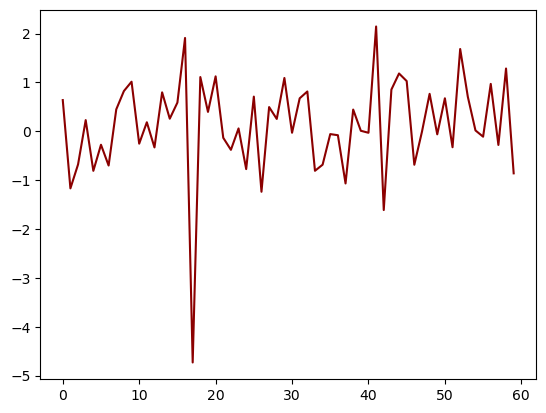

In [21]:
plt.plot(rf_results['actual'].values - rf_results['pred'].values, color='darkred')

RF looks promising.

## Model evaluation & selection

Now that we've employed a few applicable models, let's evaluate which one performs best.

In [24]:
# linear model error
# "results" is our OLS df
sales = results['sales'].values
ols_pred = results['predicted'].values

print(metrics.mean_absolute_error(sales, ols_pred))
print(metrics.mean_squared_error(sales, ols_pred))
print(np.sqrt(metrics.mean_squared_error(sales, ols_pred)))

1.252011229687068
2.784126314510936
1.6685701407225697


In [25]:
# log linear model error
print(metrics.mean_absolute_error(loglin_results['y_test'], loglin_results['predictions']))
print(metrics.mean_squared_error(loglin_results['y_test'], loglin_results['predictions']))
print(np.sqrt(metrics.mean_squared_error(loglin_results['y_test'], loglin_results['predictions'])))

1.23
2.945333333333335
1.7161973468495209


In [26]:
# random forest
rf_actual = rf_results['actual'].values
rf_pred = rf_results['pred'].values

print(metrics.mean_absolute_error(rf_actual, rf_pred))
print(metrics.mean_squared_error(rf_actual, rf_pred))
print(np.sqrt(metrics.mean_squared_error(rf_actual, rf_pred)))

0.7258499999999983
1.0329506166666638
1.0163417814232887


Linear vs. Log Linear:   Interesting... looks like the linear model actually did better on everything except mean absolute error. So the linear model does better with noise, while the log linear model has a better straight average result.
Given that a) in media modeling, larger errors are increasingly problematic, and b) my default is to use RMSE (the 3rd value above) barring any other reason, I'm concluding that the linear model is slightly better here.

Overall: the random forest crushed it, with far lower errors. That would be optimal to use for estimating sales and gleaning the importance of each of the features. However the linear regression will be most helpful in understanding how important each variable is. E.g. one additional unit of radio is going to produce more effects than an additional unit of TV.

Note that since the linear and log linear models did rather poorly, the data probably doesn't take their shape.

In [ ]:
...I want to get effect size so that I know whether to recommend increasing or decreasing spend anywhere

#### Ways to improve the model
* There's no accounting for effect over time; each week is treated as separate  
* We didn't optimize the RF's hyperparameters
* Using sampling to find the confidence and prediction intervals would tell us more about how confident we can be about these estimates, as detailed here https://stats.stackexchange.com/questions/562058/random-forests-confidence-intervals-and-prediction
* If we had a larger data set, especially with more independent variables, we'd want to use a multi-armed bandit approach to finding the optimal parameters (i.e. spend by channel)

## Budget Optimization

Now that we've found a model that makes accurate predictions, we can optimize its hyperparameters to find our theoretical optimal budget allocation. 

Plan:  
1. Find the average amount we can spend per week (eventually see if it's different on min and max spend weeks)
2. Use a multi-armed bandit to find the optimal spend given our constraints (https://towardsdatascience.com/multi-armed-bandits-thompson-sampling-algorithm-fea205cf31df)

Text(0, 0.5, 'Sales $')

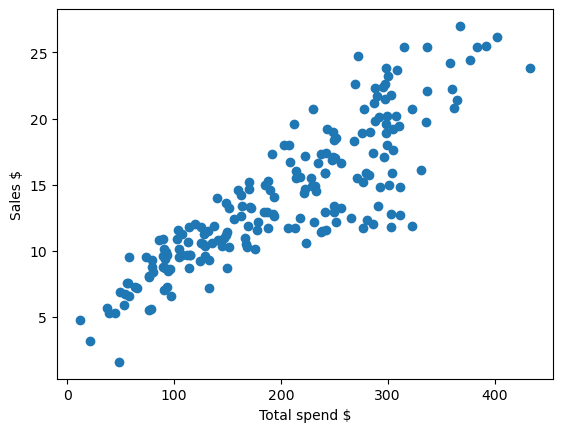

In [86]:
# There's a clear relationship between spend and sales
plt.scatter(X.sum(axis=1),y)
plt.xlabel('Total spend $')
plt.ylabel('Sales $')

In [117]:
# Let's start by assuming that we have a budget limit of $300

ns = 0 # 1/2 of newspaper_spend # I tried 0, 10, 20, and 100, and all values >0 led to decreases in sales
    # which makes sense given that we found no relation earlier

trials = pd.DataFrame({'TV': list(range(0-ns, 301-ns, 5)),
             'radio': list(range(300-ns, -1-ns, -5)),
             'newspaper': [ns*2]*len(list(range(0-ns, 301-ns, 5)))})

trials.tail()

,TV,radio,newspaper
56,280,20,0
57,285,15,0
58,290,10,0
59,295,5,0
60,300,0,0


In [118]:
# modeling it out there's a straight relationship between increasing TV spend and increasing revenue
results = rf_model.predict(trials)
results

array([ 6.193,  6.742,  7.471,  7.948,  8.474,  9.009,  9.042, 10.591,
       11.182, 11.877, 12.106, 12.12 , 12.121, 12.459, 12.739, 13.016,
       13.714, 13.8  , 13.859, 13.921, 13.986, 14.733, 15.26 , 15.322,
       15.487, 15.946, 16.791, 18.782, 19.226, 20.177, 20.177, 20.514,
       20.765, 20.848, 21.075, 21.642, 22.062, 22.123, 22.3  , 23.109,
       23.237, 23.307, 23.388, 23.662, 24.12 , 24.215, 24.298, 24.512,
       24.672, 25.03 , 25.124, 24.222, 23.605, 21.258, 20.576, 17.436,
       15.491, 15.457, 14.84 , 12.748, 11.887])

Text(0, 0.5, 'Sales $')

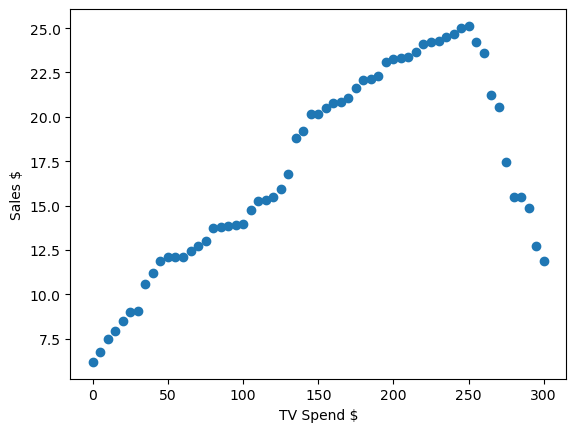

In [121]:
plt.scatter(trials['TV'],results)
plt.xlabel('TV Spend $')
plt.ylabel('Sales $')

In [133]:
# pull out our optimal allocation
x_y = trials.copy()
x_y['sales'] = results
optimal_alloc = x_y.query('sales == sales.max()')
optimal_alloc

,TV,radio,newspaper,sales
50,250,50,0,25.124


In [157]:
# let's test our assumption that more spend = more sales at this allocation
# this is a fairly manual way to define it but we only have a few columns
extrap_trials = pd.DataFrame({'TV': optimal_alloc.TV.values*[x/10 for x in list(range(1,21,1))],
             'radio': optimal_alloc.radio.values*[x/10 for x in list(range(1,21,1))],
             'newspaper': optimal_alloc.newspaper.values*[x/10 for x in list(range(1,21,1))]})

extrap_trials.head()

,TV,radio,newspaper
0,25.0,5.0,0.0
1,50.0,10.0,0.0
2,75.0,15.0,0.0
3,100.0,20.0,0.0
4,125.0,25.0,0.0


In [159]:
results = rf_model.predict(extrap_trials)
results

array([ 7.079,  9.488, 11.027, 11.611, 13.202, 17.094, 18.142, 20.943,
       23.072, 25.124, 26.047, 25.928, 25.928, 25.928, 25.928, 25.928,
       25.928, 25.928, 25.928, 25.928])

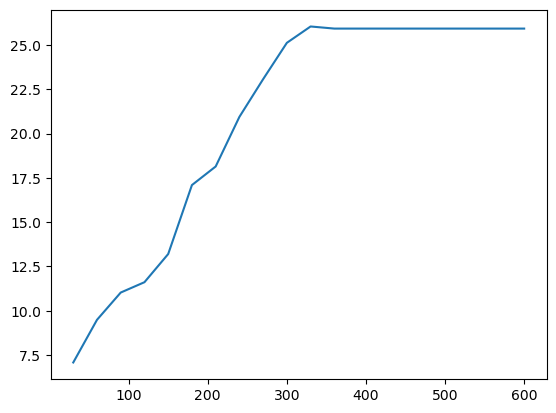

In [164]:
# Sales peak at $360 of spend, leveling off after that
plt.plot(extrap_trials.sum(axis=1).values, results)
plt.xlabel('Total spend $')
plt.ylabel('Sales $')

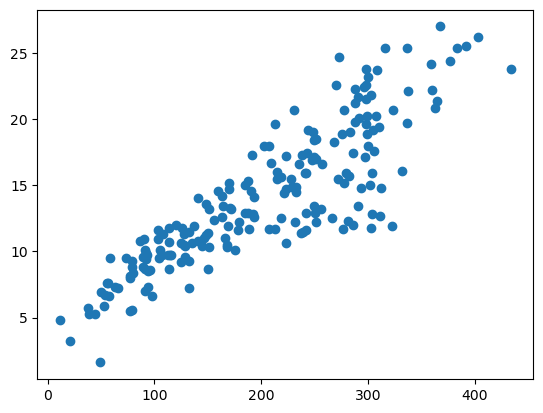

In [167]:
# looking at our dataset, this is a bit surprising, since visually it seems like there's 
# slightly higher sales around $380; but the data is thin, and I wouldn't be confident investing higher than that
plt.scatter(X.sum(axis=1).values, y)

Text(0, 0.5, 'Sales $')

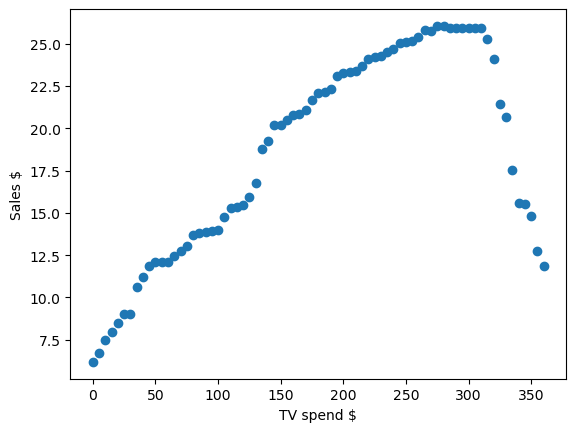

In [175]:
# let's recalibrate now, at $360 of spend

ns = 0 # 1/2 of newspaper_spend # I tried 0, 10, 20, and 100, and all values >0 led to decreases in sales
    # which makes sense given that we found no relation earlier

trials = pd.DataFrame({'TV': list(range(0-ns, 361-ns, 5)),
             'radio': list(range(360-ns, -1-ns, -5)),
             'newspaper': [ns*2]*len(list(range(0-ns, 361-ns, 5)))})

results = rf_model.predict(trials)

plt.scatter(trials['TV'],results)
plt.xlabel('TV spend $')
plt.ylabel('Sales $')

Text(0, 0.5, 'Sales $')

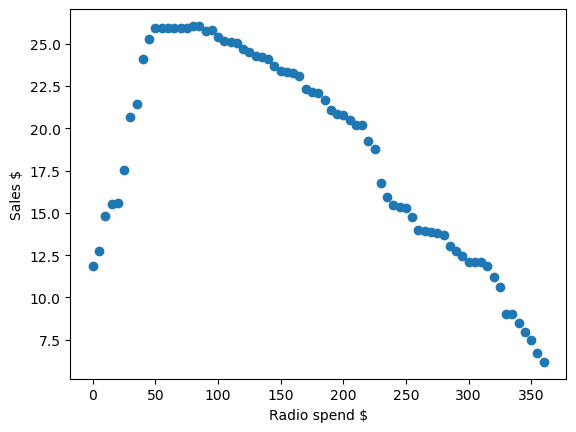

In [173]:
plt.scatter(trials['radio'],results)
plt.xlabel('Radio spend $')
plt.ylabel('Sales $')

Interesting. There's a modest range where distribution between TV and radio doesn't matter

In [176]:
# pull out our optimal allocation
x_y = trials.copy()
x_y['sales'] = results
optimal_alloc = x_y.query('sales == sales.max()')
optimal_alloc

,TV,radio,newspaper,sales
55,275,85,0,26.047


The distribution above does increase sales over our previous result, however since spend is higher, we'd have to know the value of a sale to determine whether the spend was worth it.

In [177]:
85/275

0.3090909090909091

In [178]:
50/250

0.2

In [179]:
85/(275+85)

0.2361111111111111

The ratio of spend between radio:TV actually differs quite a bit depending on how much you're willing to spend. If we're trying to simply maximize sales, we'd want to spend $360, 24\% of which would be on radio.

In [71]:
# Define the range of parameter values
a_range = np.arange(1, 50)
b_range = np.arange(1, 50)
c_range = np.arange(1, 280)

# Define the total number of trials and the number of arms to pull per trial
num_trials = 1000
num_arms = 10

# Initialize the rewards and pulls arrays
rewards = np.zeros((num_arms, len(a_range), len(b_range), len(c_range)))
pulls = np.zeros((num_arms, len(a_range), len(b_range), len(c_range)))

# Define the function to generate the predictions using the rf_model
def generate_predictions(a, b, c):
    # Generate a 3 column array of random data
#     data = np.random.rand(100, 3)
    data = pd.DataFrame(data = np.random.rand(100, 3)*20, columns = ['TV', 'radio', 'newspaper'])
    # Use the rf_model to generate predictions
    predictions = rf_model.predict(data)
    return predictions

# Define the function to select the arm to pull based on the rewards and pulls arrays
def select_arm(rewards, pulls, t):
    # Calculate the exploration-exploitation tradeoff parameter
    epsilon = 0.1
    # Calculate the total number of pulls across all arms
    total_pulls = np.sum(pulls)
    # Calculate the average reward for each arm
    avg_rewards = np.sum(rewards, axis=1) / np.maximum(pulls, 1)
    # Calculate the upper confidence bound for each arm
    ucb = avg_rewards + np.sqrt(2 * np.log(total_pulls) / np.maximum(pulls, 1))
    # Select the arm with the highest UCB value
    arm = np.argmax(ucb)
    # Add some random noise to encourage exploration
    if np.random.rand() < epsilon:
        arm = np.random.randint(num_arms)
    return arm

# Run the multi-armed bandit test
for t in range(num_trials):
    # Select the arm to pull
    arm = select_arm(rewards, pulls, t)
    # Select the parameter values for the arm
    a_idx, b_idx, c_idx = np.unravel_index(arm, (len(a_range), len(b_range), len(c_range)))
    a = a_range[a_idx]
    b = b_range[b_idx]
    c = c_range[c_idx]
    # Generate predictions using the selected parameter values
    predictions = generate_predictions(a, b, c)
    # Calculate the reward based on the accuracy of the predictions
    accuracy = np.mean(predictions == 0.5)
    reward = accuracy
    # Update the rewards and pulls arrays
    rewards[arm] += reward
    pulls[arm] += 1

# Select the parameter values with the highest reward
best_arm = np.argmax(np.sum(rewards, axis=0))
best_a_idx, best_b_idx, best_c_idx = np.unravel_index(best_arm, (len(a_range), len(b_range), len(c_range)))
best_a = a_range[best_a_idx]
best_b = b_range[best_b_idx]
best_c = c_range[best_c_idx]
print("Best parameters: a={}, b={}, c={}".format(best_a, best_b, best_c))

# This code defines the range of parameter values for `a`, `b`, and `c`, as well as the total number of trials and the number of arms to pull per trial. It initializes the rewards and pulls arrays to keep track of the rewards and pulls for each arm and parameter combination.

# The `generate_predictions` function generates a 3 column array of random data and uses the `rf_model` to generate predictions. The `select_arm` function selects the arm to pull based on the rewards and pulls arrays, using the upper confidence bound (UCB) algorithm to balance exploration and exploitation.

# The main loop of the code runs the multi-armed bandit test for the specified number of trials. It selects the arm to pull using the `select_arm` function, selects the parameter values for the arm, generates predictions using the `generate_predictions` function, calculates the reward based on the accuracy of the predictions, and updates the rewards and pulls arrays.

# After the test is complete, the code selects the parameter values with the highest reward and prints them out. These are the optimal parameters to feed into the `rf_model`.

ValueError: operands could not be broadcast together with shapes (10,49,279) (10,49,49,279) 

## Next Steps (notes to self)

* Play with the random forest model (which got the best results) to find the point of maximum return, looking through different budget allocations.
* Check your assumptions with a) the linear model, and b) a new test/train split
* Clean it up and publish, including getting the "ways to improve model" together